<a href="https://colab.research.google.com/github/Seungwoo20/aiffel_project_son/blob/main/%5BGC_05%5DCAM_Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 01. Setup

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libararies
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
(ds_train, ds_test), ds_info = tfds.load(
        'stanford_dogs',
        split=['train', 'test'],
        shuffle_files = True,
        with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete5NTU6Q/stanford_dogs-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete5NTU6Q/stanford_dogs-test.tfrecord*...:   0%…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


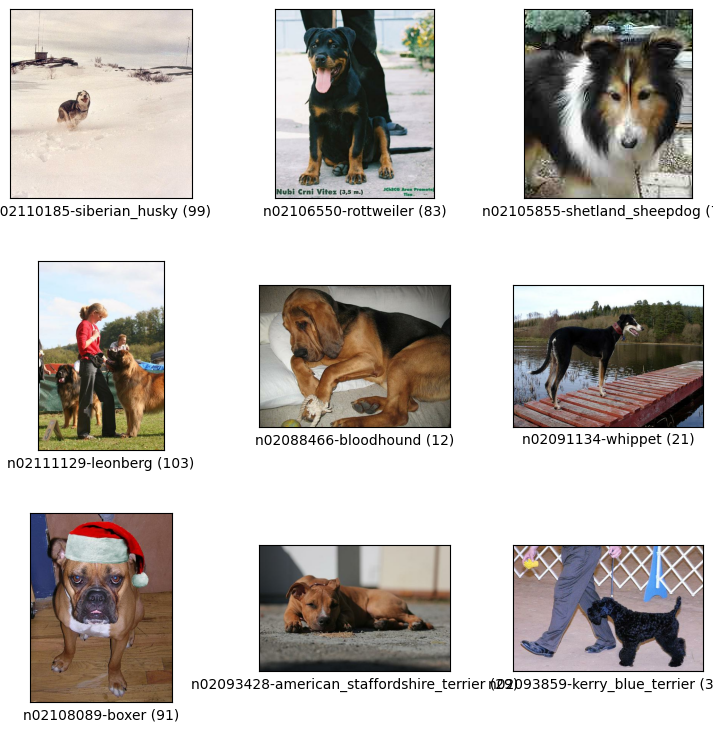

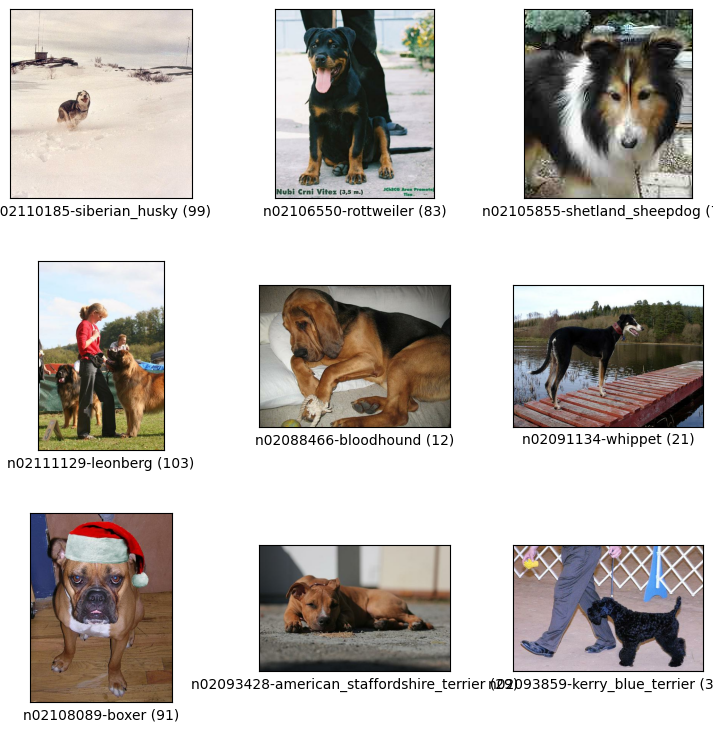

In [5]:
tfds.show_examples(ds_train, ds_info)

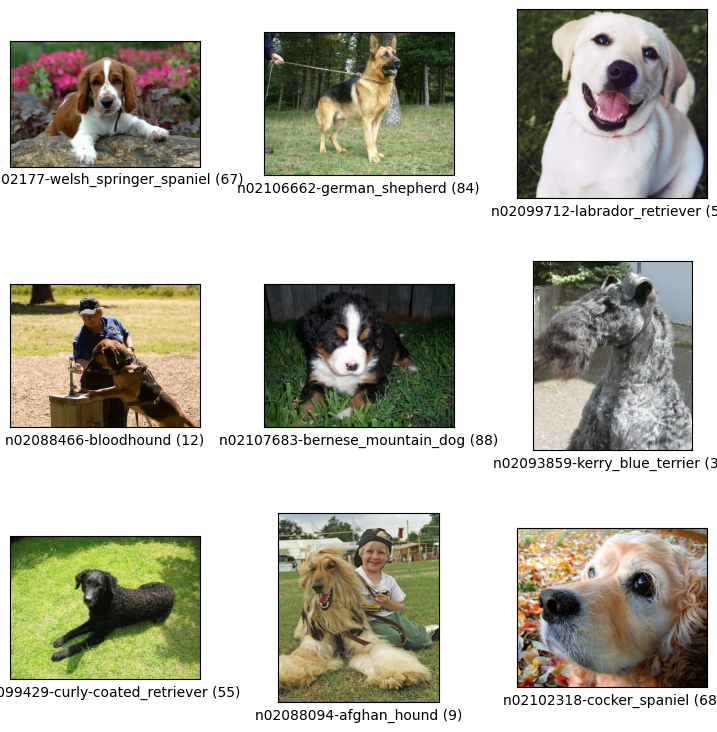

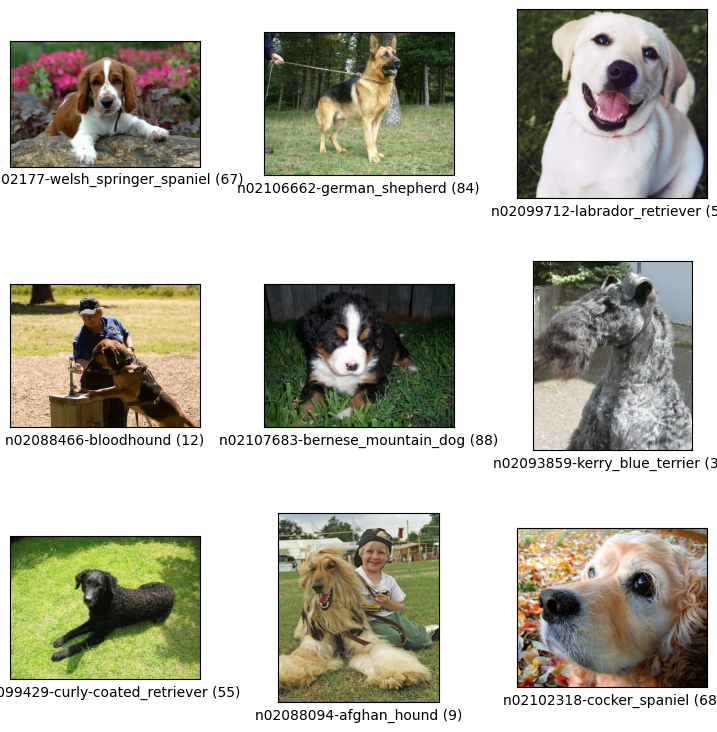

In [6]:
tfds.show_examples(ds_test, ds_info)

In [7]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
    }),
})

# 02. Base Model 구축

In [8]:
# label 갯수 출력
num_classes = ds_info.features['label'].num_classes

# 기본 모델
base_model = keras.applications.resnet50.ResNet50(
    include_top = False, # imagenet의 분류기 fully connected layer 제거
    weights='imagenet',
    input_shape = (224,224,3),
    pooling = 'avg' # average pooling layer 적용
)

# Cam model
x= base_model.output
preds = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94765736/94765736 [==============================] - 5s 0us/step


In [9]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

# 03. preprocessing

In [10]:
def normalize_and_resize_img(input): # input : tensorflow datasets
    # Normalizes images : 'unit8' >> 'float32'
    image = tf.image.resize(input['image'], [224,224])
    input['image'] = tf.cast(image, 'float32') / 255. # normalize
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16): # ds : tensorflow data sets
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)

    # 시간절약; 데이터세트 요소를 미리 가져와서 세팅해놓음
    # 요소의 수는 AUTO로(batch보다 크거나 같아야함.)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [11]:
# apply train/test preprocessing
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치 모양 확인
for i in ds_train_norm.take(1):
    image, label = i
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


# 04. 모델 학습

In [12]:
cam_model.compile(
    # label이 0,1보다 큰 자연수 집합이기 때문에 sparse 사용
    loss = 'sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)


In [13]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch = int(ds_info.splits['train'].num_examples/16),
    validation_steps = int(ds_info.splits['test'].num_examples/16),
    epochs=2,
    validation_data = ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/2
750/750 [==============================] - 205s 228ms/step - loss: 2.2476 - accuracy: 0.4327 - val_loss: 3.8960 - val_accuracy: 0.1374
Epoch 2/2
750/750 [==============================] - 177s 236ms/step - loss: 0.6492 - accuracy: 0.8275 - val_loss: 1.2284 - val_accuracy: 0.6433


In [14]:
import os

# model 저장
cam_model_path = '/content/drive/MyDrive/data/cam_model1.h5'
cam_model.save(cam_model_path)
print('save complete!')


save complete!


In [15]:
# 모델 불러오기
cam_model_path = '/content/drive/MyDrive/data/cam_model1.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

# 05. CAM

In [16]:
def get_one(ds): # ds : tensorflow datasets
    ds = ds.take(1) # image 1개

    # tensorflow datasets로 돼있기 때문에 list로 바꿔줍니다.
    sample_data = list(ds.as_numpy_iterator())
    '''
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    '''
    return sample_data[0] # dictionary return

108


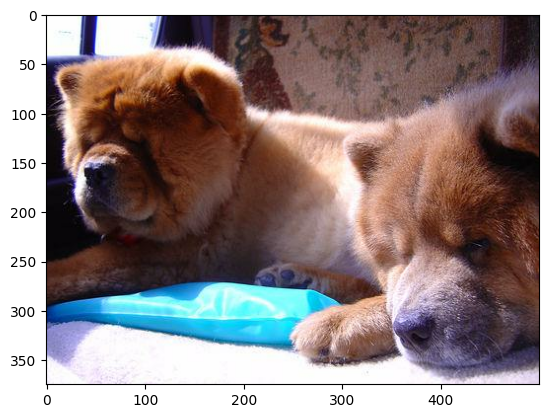

In [17]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [18]:
def generate_cam(model, item): # model : 학습한 모델, item : dictionary
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]

    img_tensor, class_idx = normalize_and_resize_img(item)

    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])

    # 이미지가 한 개라서 dimension 하나 늘려줌.(axis=0)
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor,  0))
    conv_outputs = conv_outputs[0, :, :, :] # 3차원 텐서로 다시 축소

    class_weights = model.layers[-1].get_weights()[0] # shape : (chaanel, classes size)

    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2]) # shape : (height, width)
    for i,w in enumerate(class_weights[:, class_idx]): # channel 갯수만큼 반복
        cam_image += w * conv_outputs[:, :, i] # 픽셀별로 sum

    cam_image /= np.max(cam_image) # activation score normalize
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지 크기로 resize
    return cam_image

<function matplotlib.pyplot.show(close=None, block=None)>

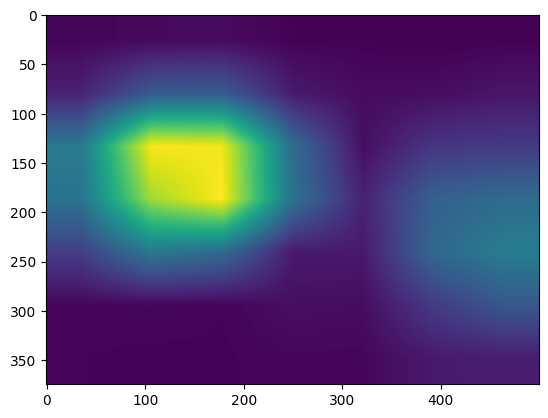

In [19]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show

In [20]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)

    # img = alpha*(src1)+beta(src2)+0.0
    merged_img = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_img

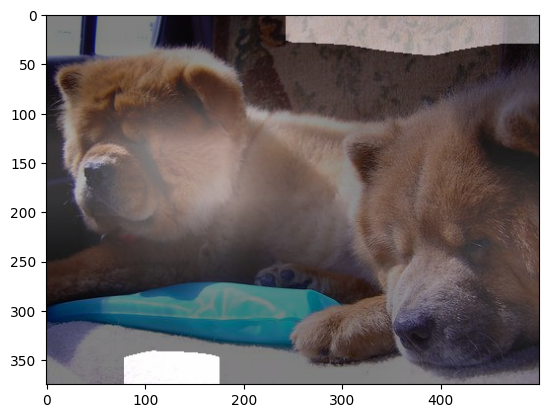

In [21]:
origin_image = item['image'].astype(np.uint8)

# cam_image channel 1개라 3개로 만들어줌
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

# 06. Grad_CAM

108


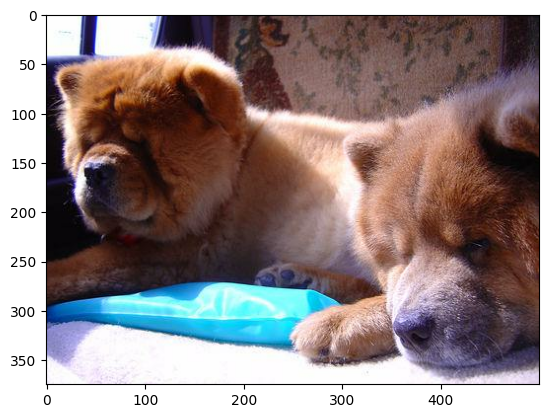

In [22]:
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [23]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])

    with tf.GradientTape() as tape: # backprop시 gradient변화량 저장
        # conv_output shape : 4차원, pred shape : (1,class size)
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))

        loss = pred[:, class_idx]
        output = conv_output[0] # shape : (height, width, channel size)
        grad_val = tape.gradient(loss, conv_output)[0] # output과 pred사이의 gradient

    weights = np.mean(grad_val, axis=(0,1)) # GAP, weights변수 shape : (1,1,channel size)
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2]) # grad_cam_image shape : (height, width)
    for k,w in enumerate(weights):
        grad_cam_image += w * output[:,:,k]

    grad_cam_image = tf.math.maximum(0, grad_cam_image) # 0보다 큰 것만 get
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

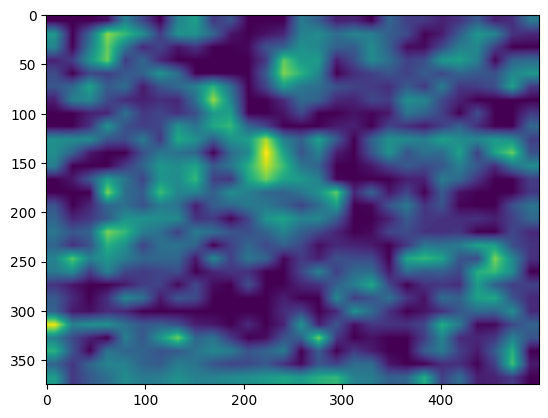

In [24]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

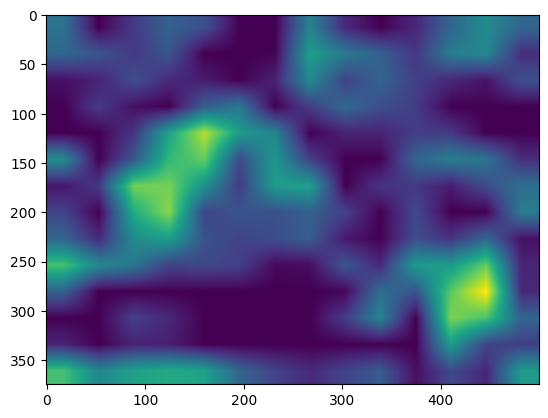

In [25]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

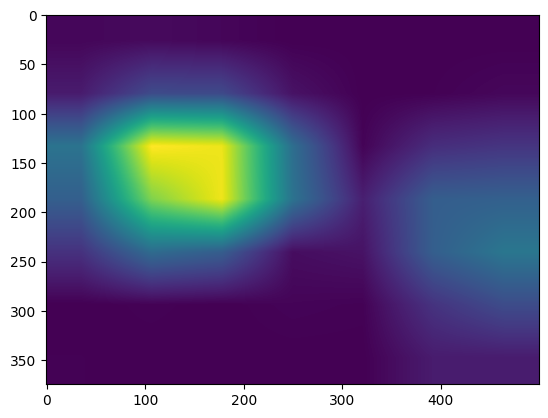

In [26]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

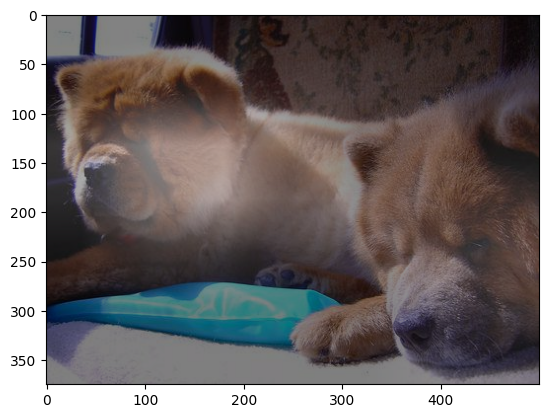

In [27]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

# 06. Bounding Box

### CAM

In [28]:
# bounding box 좌표구하는 함수
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies]=0
    cam_image = (cam_image*255).astype(np.uint8)

    # 윤곽선찾기
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # findContours(image, 검색모드, contour approximation method)
    cnt = contours[0]

    # 최소점들로 가장 작은 사각형 찾기
    rotated_rect = cv2.minAreaRect(cnt)

    # 모서리 네 개 점 얻기
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [29]:
cam_rect = get_bbox(cam_image)
cam_rect

array([[-38, 308],
       [  8,   6],
       [543,  89],
       [496, 391]])

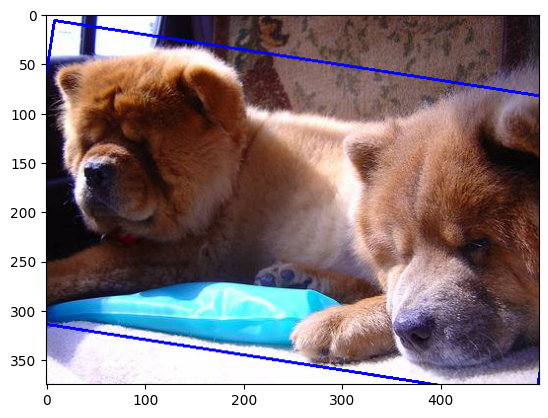

In [30]:
cam_image = copy.deepcopy(item['image'])

# drawContours(image, list(point),윤곽선 매개변수, color, thickness)
cam_image = cv2.drawContours(cam_image, [cam_rect], 0, (0,0,255), 2)
plt.imshow(cam_image)
plt.show()

### Grad CAM

In [31]:
grad_rect = get_bbox(grad_cam_image)
grad_rect

array([[-43, 299],
       [  9,   4],
       [548, 101],
       [494, 396]])

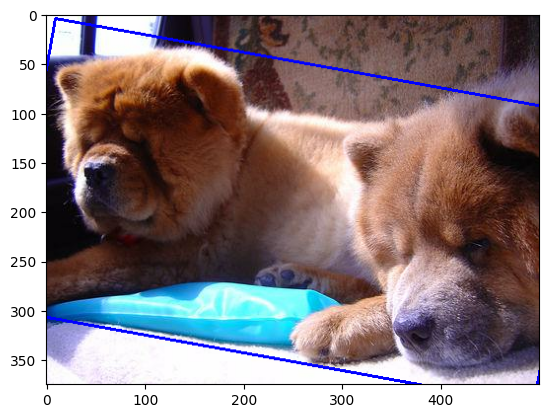

In [32]:
grad_image = copy.deepcopy(item['image'])
grad_image = cv2.drawContours(grad_image, [grad_rect], 0, (0,0,255), 2)
plt.imshow(grad_image)
plt.show()

### Ground Truth

In [42]:
ground_rect = item['objects']['bbox']
l,t,r,b = ground_rect[0][1],ground_rect[0][0],ground_rect[0][3],ground_rect[0][2]
l2,t2,r2,b2 = ground_rect[1][1],ground_rect[1][0],ground_rect[1][3],ground_rect[1][2]
ground_rect

array([[0.13066667, 0.488     , 0.96533334, 0.998     ],
       [0.072     , 0.        , 0.784     , 0.678     ]], dtype=float32)

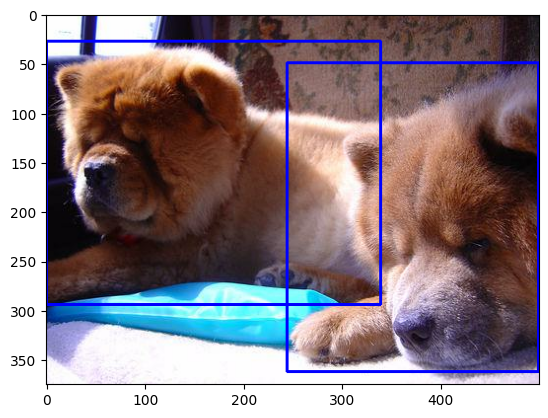

In [43]:
ground_image = copy.deepcopy(item['image'])

width = np.float32(ground_image.shape[1])
height = np.float32(ground_image.shape[0])

cv2.rectangle(ground_image, (round(l*width), round(t*height)), (round(r*width), round(b*height)), (0, 0, 255), 2)
cv2.rectangle(ground_image, (round(l2*width), round(t2*height)), (round(r2*width), round(b2*height)), (0, 0, 255), 2)
plt.imshow(ground_image)
plt.show()

# 07. CAM vs Grad_CAM IoU 비교

### bbox 최대 최소 계산

In [35]:
# x,y 0~1로 조정
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]), # y_min
        rect[:,0].min()/float(image.shape[1]), # x_min
        rect[:,1].max()/float(image.shape[0]), # y_max
        rect[:,0].max()/float(image.shape[1]), # x_max
    ]
    return bbox

In [36]:
# CAM bbox
cam_bbox = rect_to_minmax(cam_rect, item['image'])
cam_bbox

[0.016, -0.076, 1.0426666666666666, 1.086]

In [37]:
# Grad CAM bbox
grad_bbox = rect_to_minmax(grad_rect, item['image'])

In [38]:
# ground truth bbox
item['objects']['bbox']

array([[0.13066667, 0.488     , 0.96533334, 0.998     ],
       [0.072     , 0.        , 0.784     , 0.678     ]], dtype=float32)

### IoU

In [39]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min = max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])

    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea+boxBArea-interArea)

    return iou

In [40]:
cam_iou = get_iou(cam_bbox, item['objects']['bbox'][0])
grad_iou = get_iou(grad_bbox, item['objects']['bbox'][0])

print(f'CAM IoU : {cam_iou}\n\nGrad CAM IoU : {grad_iou}')

CAM IoU : 0.3568187253072344

Grad CAM IoU : 0.3445172337198657


# 08. 결과

1. 정량적 분석정도

bounding box를 이용한 IoU만 고려했을 땐 CAM의 수치가 0.1정도 더 높게 나왔습니다.


2. 정성적 분석

- CAM\
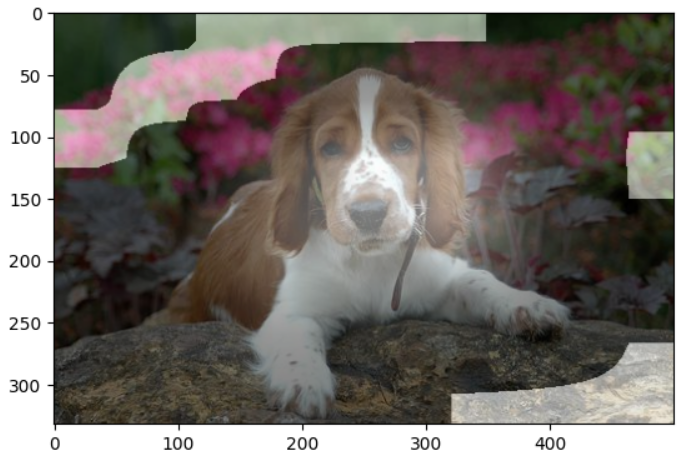
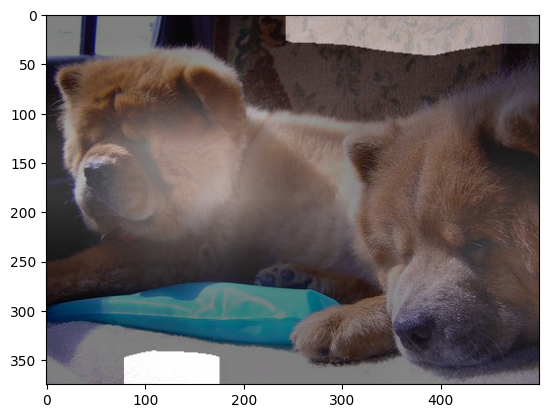


- Grad CAM\
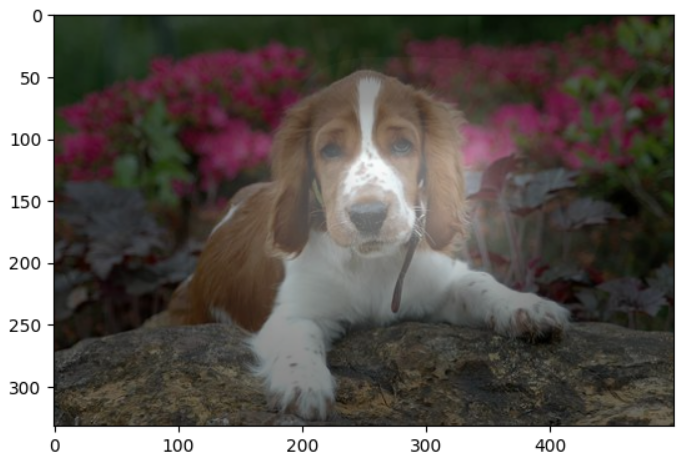
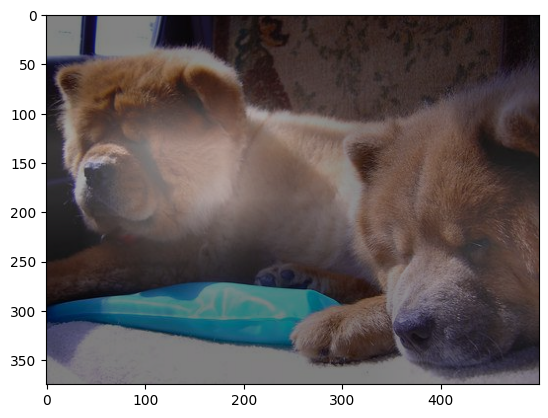![image.png]()

하지만 CAM을 통해 나온 이미지와 원본 이미지를 blending한 이미지는 강아지가 없는 배경에도 밝은 색을 띕니다.


그에 반면 Grad_CAM으로 나온 이미지의 bleding 이미지는 강아지가 있는 부분만 조금 더 밝은 것을 확인할 수 있습니다.


확인해본 layer가 마지막에서 3번째인 마지막 conv block의 output이라는 점을 감안하면 배경을 보고 class를 판단했다는 건 조금 이상합니다.


따라서 어딜보고 class라고 판단하는지 알아보려는 취지엔 Grad_CAM의 성능이 조금 더 좋다고 볼 수 있을 것 같습니다.

# 회고



결과 사진을 확인해보니 같은 클래스의 객체인 강아지가 두 마리일 때도 두마리 다 들어가는 bouding box가 만들어졌습니다.image classification 문제인데도 두 객체 모두 잡아내는 것을 보면 detection시에도 잘 작동할 것 같다는 생각이 들었습니다. 그래서 추 후에 segmentation이나 detection모델에도 적용해보고 확인해보면 좋을 것 같습니다.